## IS2_S2_cryo2ice_search.ipynb
Alek Petty, adapted from an earlier M. Bagnardi script.

Deescription:
- This notebook searches for semi-coincident ICESat-2 and Sentinel-2 data.
- The code finds Sentinel-2 images with ICESat-2 data falling within the image's footprint.
- The code was updated to read in ATL07 data from the new cloud storage using earthdata, see relevant tutorials:
     https://github.com/nsidc/NSIDC-Data-Tutorials/blob/main/notebooks/ICESat-2_Cloud_Access/ATL06-direct-access_rendered.ipynb
     https://github.com/nsidc/NSIDC-Data-Tutorials/blob/main/notebooks/ICESat-2_Cloud_Access/nsidc_daac_uwg_cloud_access_tutorial_rendered.ipynb (No longer hosted!!) 
 
To do:
- Should we use CLOUD_COVERAGE_ASSESSMENT or CLOUDY_PIXEL_PERCENTAGE?
- Check all beams instead of just the middle beam.
- Add in other imagery/satellite sensors.

Notes:
- Using the middle strong beam but could be easily adapted to check across all beams.
- Tested with the adapted 'geo' conda env on cryocloud if you want to convert into a python script.

Output:

Update history:
 - Current notebook created in Sep 2024.


In [1]:
# Uncomment these out when running for the first time on cryocloud
#%pip install sentinelsat
#%pip install earthdata
#%pip install astropy

In [2]:
# Load modules
import datetime as dt
import h5py
import pandas as pd
# Need to do this for geopandas for some reason
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import glob
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image
import io
import requests
import time
import earthaccess
import xarray as xr
from datetime import datetime
from datetime import timedelta

#from astropy.time import Time
#from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

import ee
import geemap
#Initialize the Google Earth Engine API, handling authentication if necessary.
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [3]:
# ICESat-2/earthaccess stuff
auth = earthaccess.login()



Enter your Earthdata Login username:  akpetty
Enter your Earthdata password:  ········


In [4]:
# Select search period 
date1 = "2019-05-01"
date2 = "2019-05-02"

granule_search = earthaccess.search_data(
        short_name = 'ATL07',
        #version = '006',
        cloud_hosted = True,
        # Arctic for now
        bounding_box = (-180, 70, 180, 90),
        temporal = (date1, date2)
)

In [5]:
# lazily open the files here, shouldn't take long which is what's great about this approach
granules = earthaccess.open(granule_search)

QUEUEING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/29 [00:00<?, ?it/s]

In [6]:
# See here for some different access options, for different types of file generally:
#https://earthaccess.readthedocs.io/en/latest/howto/access-data/

#import xarray as xr
#files = earthaccess.open(results)
#ds = xr.open_mfdataset(files)

## if the data set is cloud-hosted there will be S3 links available. The access parameter accepts "direct" or "external". Direct access is only possible if you are in the us-west-2 region in the cloud.
# Direct not working for some reason
#data_links = [granule.data_links(access="external") for granule in granule_search]


In [7]:
granules = granules[0:2]

In [8]:
#find the matched S2 images for each IS2 file
coincident_S2_images=[]

# S2 IDs
coincident_S2_image_ids=[]

#S2 coordinates
S2_coords=[]

#number of S2 images for each IS2 granule
number_of_coincident_scenes_in_granule=[]

# coordinate tracks for each coincident IS2 granule
is2_coordinate_tracks_matched=[] 

# save ATL07 info for the coincident S-2 tracks
ATL_midtimes_matched=[]
ATL_filenames_matched=[]

# Loop over ICESat-2 granules
# Coarsen by this number of data points to speed things up, can play with this more as desired
NPTS=10
# Time difference in minutes
deltatime=180
# Max cloud cover in the S-2 images
max_cloud_cover=100

# filter data close to land (m)
dist_land_mask=10000

image_catalog = "S2_SR"
i=0
for granule in granules:
    
    print(i, granule)
    
    # Open files (not found a way of not needing to do this..)
    #atl07_file = earthaccess.open(granule)
    ATL = h5py.File(granule, 'r')
    
    orientation = ATL['/orbit_info/sc_orient'][0]

    # Only use central strong beam locations
    if orientation == 0:
        beamID = 'gt2l'
    elif orientation == 1:
        beamID = 'gt2r'
    else:
        print('Spacecraft orientation not found.')

    # Extract data info from granule
    ATL_start_time = ATL['/ancillary_data/data_start_utc'][0]
    ATL_start = pd.to_datetime(ATL_start_time[:-8].decode('utf-8'), format='%Y-%m-%dT%H:%M:%S')
    ATL_end_time = ATL['/ancillary_data/data_end_utc'][0]
    ATL_end = pd.to_datetime(ATL_end_time[:-8].decode('utf-8'), format='%Y-%m-%dT%H:%M:%S')

    ATL_lon = ATL[beamID + '/sea_ice_segments/longitude'][:]
    ATL_lat = ATL[beamID + '/sea_ice_segments/latitude'][:]

    # read in the new dist to land variable to filter these values out now we have a lot more land data in rel006!
    ATL_dist_land = ATL[beamID+'/sea_ice_segments/stats/dist2land'][:]
    ATL_lon = ATL_lon[ATL_dist_land>dist_land_mask]
    ATL_lat = ATL_lat[ATL_dist_land>dist_land_mask]
    atl07_coords = list(zip(ATL_lon[::NPTS], ATL_lat[::NPTS])) 
    
    # Use astropy to convert from gps time to datetime
    #GPS_epoch = ATL['ancillary_data/atlas_sdp_gps_epoch'][:]
    #GPS_time = ATL[beamID + '/sea_ice_segments/delta_time'][::NPTS] + GPS_epoch
    #ATL_tgps = Time(GPS_time, format='gps')
    #ATL_utc = ATL_tgps.utc.iso
    
    
    #create a feature collection representing a line from a list of valid latitude and longitude coordinate points.
    feature_track_temp = ee.FeatureCollection(ee.Geometry.LineString(coords=atl07_coords, proj='EPSG:4326', geodesic=True))
    
    roi = feature_track_temp.geometry()
    
    # Query Sentinel-2 images using ATL07 file information
    #L1C data: COPERNICUS/S2_HARMONIZED S2 (NOT FINDING ANYTHING)
    #L2A data: COPERNICUS/S2_SR_HARMONIZED COPERNICUS/S2_SR (this one is what Wenxuan used)
    
    imagecollection=ee.ImageCollection("COPERNICUS/"+image_catalog).filterBounds(roi)\
    .filterDate(ATL_start- dt.timedelta(minutes=deltatime), ATL_end+ dt.timedelta(minutes=deltatime))\
    .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT', max_cloud_cover))
    #.filter(ee.Filter.lt('NODATA_PIXEL_PERCENTAGE', 10))
    
    print('\nCoincident S2 images:', imagecollection.size().getInfo())
    if imagecollection.size().getInfo()>0:
        print('Coincident S2 image FOUND')
        
        # save number of images
        number_of_coincident_scenes_in_granule.append(imagecollection.size().getInfo()) 

        # save actual image collection
        coincident_S2_images.append(imagecollection)

        # S2 image IDs
        S2_ids = [imagecollection.toList(imagecollection.size().getInfo()).getInfo()[i]['id'] for i in range(0, imagecollection.size().getInfo())]
        coincident_S2_image_ids.append(S2_ids)

        # save first coordinte of first image found 
        S2_coord = imagecollection.toList(imagecollection.size().getInfo()).getInfo()[0]['properties']['system:footprint']['coordinates'][0]
        S2_coords.append(S2_coord)
        
        is2_coordinate_tracks_matched.append(feature_track_temp)
        ATL_mid = ATL_start + (ATL_end-ATL_start)/2
        ATL_midtimes_matched.append(ATL_mid)
        ATL_filenames_matched.append(granule)
        print('Done with granule.')
    
    print('\n\n')
    i+=1



0 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/05/01/ATL07-01_20190430235014_05000301_006_02.h5>


/srv/conda/envs/notebook/lib/python3.11/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)



Coincident S2 images: 10
Coincident S2 image FOUND
Done with granule.



1 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/05/01/ATL07-01_20190501012431_05010301_006_02.h5>

Coincident S2 images: 8
Coincident S2 image FOUND
Done with granule.





In [9]:
coincident_S2_images

In [10]:
ATL_midtimes_matched

[Timestamp('2019-05-01 00:15:29'), Timestamp('2019-05-01 01:48:11')]

In [11]:
granule

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/05/01/ATL07-01_20190501012431_05010301_006_02.h5>

In [12]:
coincident_S2_image_ids

[['COPERNICUS/S2_SR/20190430T212049_20190430T212043_T16XEP',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T16XEQ',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XMJ',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XMK',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNK',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNL',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNM',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNN',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T18XVQ',
  'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T18XVR'],
 ['COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XDJ',
  'COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XDK',
  'COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XEJ',
  'COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XEK',
  'COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XEL',
  'COPERNICUS/S2_SR/20190430T230129_20190430T230125_T13XEM',
  'COPERNICUS/S2_SR/201

In [13]:
# Save to a CSV file
#import csv
#with open('../Data/search_output/coincident_S2_image_ids_dt'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog+'csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(coincident_S2_image_ids)
    
#np.save('../Data/search_output/S2_coords'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, S2_coords)
#np.save('../Data/search_output/number_of_coincident_scenes_in_granule'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, number_of_coincident_scenes_in_granule)
#np.save('../Data/search_output/is2_coordinate_tracks_matched'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, is2_coordinate_tracks_matched)
#np.save('../Data/search_output/ATL_midtimes_matched'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, ATL_midtimes_matched)
#np.save('../Data/search_output/ATL_filenames_matched'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, ATL_filenames_matched)
  

In [14]:
# Save the output
#np.save('../Data/search_output/coincident_S2_image_ids_dt'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog, coincident_S2_image_ids)

        

In [15]:
# Save one of the coincident images
# Start an export task

save_image=False

if save_image:
    image = ee.Image('COPERNICUS/S2_SR/20210425T113629_20210425T113626_T41XNL')
    
    export_task = ee.batch.Export.image.toDrive(
        image=image,
        description='Sentinel-2_Export',  # Name of the export task
        folder='EarthEngineExports',  # Destination folder in Google Drive
        fileNamePrefix='sentinel2_image',  # Filename prefix in Google Drive
        #region=roi.getInfo()['coordinates'],  # Exported region
        scale=10,  # Scale in meters (Sentinel-2 native resolution)
        #crs='EPSG:4326',  # Coordinate Reference System
        #maxPixels=1e9  # Maximum number of pixels allowed
    )
    
    # Start the export task
    export_task.start()

In [16]:
# MOSAIC images
coincident_S2_mosaics=[]
for imagecollection in coincident_S2_images:
    # mosaic images and save that too
    # more ideas here: https://developers.google.com/earth-engine/apidocs/ee-imagecollection-mosaic
    # could add cloud filters and other things here, for now just creudely mosaic them...
    print('Mosaicing images...')
    mosaic = imagecollection.mosaic()
    coincident_S2_mosaics.append(mosaic)
print('Mosaicing images...')

Mosaicing images...
Mosaicing images...
Mosaicing images...


In [17]:
Map = geemap.Map()

coincident_granule_num = 0

#coincident_S2_images
#s2_id = coincident_S2_images[coincident_granule_num].aggregate_first('id').getInfo()
mean_cloud_cover = coincident_S2_images[coincident_granule_num].aggregate_mean('CLOUD_COVERAGE_ASSESSMENT').getInfo()
#mean_cloud_pixel = coincident_S2_images[coincident_granule_num].aggregate_mean('CLOUDY_PIXEL_PERCENTAGE').getInfo()
mean_time_delta = coincident_S2_images[coincident_granule_num].aggregate_mean('system:time_start').getInfo()
time_s2 = datetime(1970, 1, 1) + timedelta(seconds = mean_time_delta/1000) 

print(ATL_filenames_matched[coincident_granule_num])
print('Coincident S-2 images', coincident_S2_image_ids[coincident_granule_num])

time_is2_m = ATL_midtimes_matched[coincident_granule_num]
time_diff_mins_is2_mid = int(abs(time_is2_m-time_s2).seconds/60)
print(f"Time difference = {time_diff_mins_is2_mid} minutes between S-2 and estimated IS-2 time from middle of granule")

print(f"Cloud cover = {mean_cloud_cover} %")
#print(mean_cloud_cover, time_s2, time_is2, time_diff_mins)

mosaiced_scene = coincident_S2_mosaics[coincident_granule_num]
#img = ee.Image(mosaiced_scene).select('B4','B3','B2')

Map.addLayer(mosaiced_scene, {'bands': ['B4', 'B3', 'B2'], 'max': 10000}, 'RGB Mosaic')

# Center Map around the first image, not figured out how to instead use the mosaic for this
img = ee.Image(coincident_S2_image_ids[coincident_granule_num][0]).select('B4','B3','B2')
Map.centerObject(img, zoom = 7)
Map.addLayer(is2_coordinate_tracks_matched[coincident_granule_num], {}, "ATl07 beam (middle strong)")
#Map.to_html(outfile='./your_map.html', title='My Map', width='100%', height='880px')

Map

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/05/01/ATL07-01_20190430235014_05000301_006_02.h5>
Coincident S-2 images ['COPERNICUS/S2_SR/20190430T212049_20190430T212043_T16XEP', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T16XEQ', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XMJ', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XMK', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNK', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNL', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNM', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T17XNN', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T18XVQ', 'COPERNICUS/S2_SR/20190430T212049_20190430T212043_T18XVR']
Time difference = 174 minutes between S-2 and estimated IS-2 time from middle of granule
Cloud cover = 36.8122576 %


Map(center=[80.044169677599, -84.72553273861126], controls=(WidgetControl(options=['position', 'transparent_bg…

In [18]:
# Export the map as a PNG
#url = mosaiced_scene.getThumbURL({
#    'region': geometry.getInfo(),
#    'dimensions': 1024,
#    'format': 'png'
#})

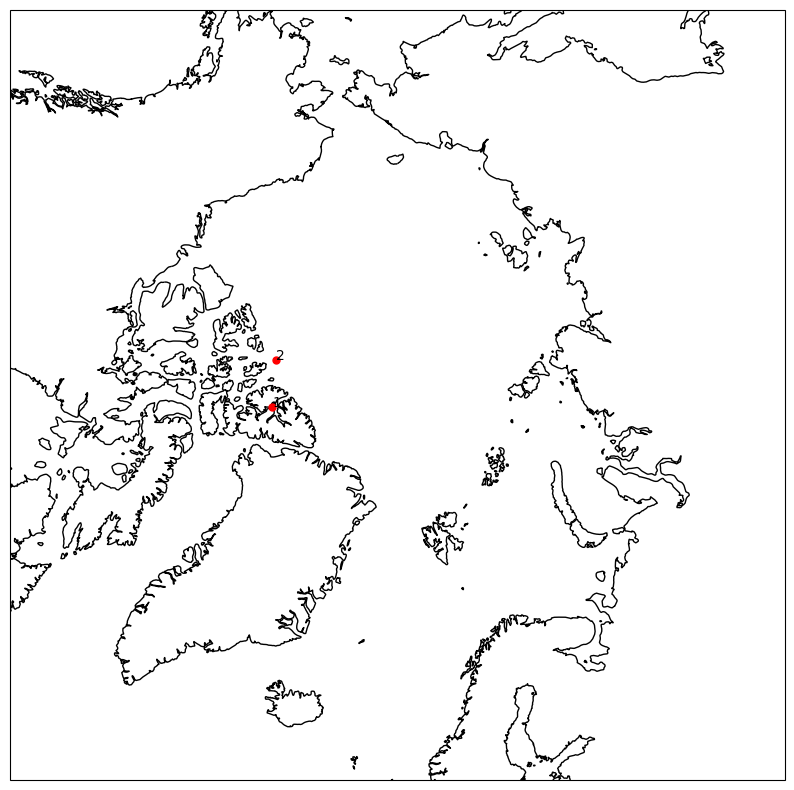

In [19]:
# Plot a little map showing the broader location of the S-2 images

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Your list of longitudes and latitudes
# Format: [(lon1, lat1), (lon2, lat2), ...]
coordinates = [(80, 80), (85, 85)]

# Create a figure and add a subplot with a North Polar Stereographic projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# Set the extent of the map to focus on the North Pole area
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Add coastlines and borders for context
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the markers based on the provided coordinates
x=1
for lon, lat in S2_coords:
    ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.Geodetic())
    ax.text(lon, lat, str(x), transform=ccrs.Geodetic())
    x+=1

plt.savefig('../Data/search_output/locations'+str(deltatime)+'_mcc'+str(max_cloud_cover)+'_dlnd'+str(dist_land_mask)+image_catalog+'.png')
# Display the plot
plt.show()


In [20]:
# In this section, we can check single coincident dataset on the map by assigning different values from non_zero_indices to test_x. 
# AP update: I dont need the time check here as it's in my function above!
granule_num=1
s2_scene_ids = coincident_S2_image_ids[granule_num]
#scene_ids = coincident_S2_image_ids[granule_num]
s2_scenes = coincident_S2_images[granule_num]
#S2_ids = [coincident_S2_image_ids[granule_num](number_of_coincident_scenes_in_granule[granule_num]).getInfo()[i]['id'] for i in range(0, number_of_coincident_scenes_in_granule[granule_num])]  
#time_diff = 3600*4 # Target time difference between ATL07 and Sentinel-2 < 3 hours
#time_IS2 = datetime.strptime(IS2_file_name[test_x][-33:-19], "%Y%m%d%H%M%S")

Map = geemap.Map()

for i in range(0, number_of_coincident_scenes_in_granule[granule_num]):
#for i in range(0, 1):
    time_start = time_start = coincident_S2_images[granule_num].toList(number_of_coincident_scenes_in_granule[granule_num]).getInfo()[i]['properties']['system:time_start']
    time_s2 = datetime(1970, 1, 1) + timedelta(seconds = time_start/1000)   
    
    img_name = os.path.basename(S2_ids[i])

    # Time difference between IS2 and S2 < defined time_diff
    #if abs(time_IS2-time_s2).seconds <= time_diff:

    print(f" {img_name}: Time difference = {int(abs(ATL_midtimes_matched[granule_num]-time_s2).seconds/60)} minutes with ICESat-2 track")
    
    img = ee.Image(s2_scene_ids[i]).select('B4','B3','B2')
    dim = img.getInfo()['bands'][0]['dimensions']
    if dim[0] > 10000 and dim[1] > 0:
        # # Download image into the local folder
        #geemap.download_ee_image(img, f"S2_{img_name}.tif", scale=50)
        Map.addLayer(img, {'min': 0, 'max': 10000}, img_name)
        #print(f" {img_name}: Time difference = {abs(time_IS2-time_s2).seconds/3600} hours with ICESat-2 track")
        #else:
        #    print(f"SKIP {img_name}: Not a full image")
   #else:
   #     print(f"SKIP {img_name}: Time difference > {time_diff/3600} hours with ICESat-2 track")
   #     Map.addLayer(img, {'min': 0, 'max': 10000}, img_name)
   #     print(f" {img_name}: Time difference = {abs(time_IS2-time_s2).seconds/3600} hours with ICESat-2 track")

Map.centerObject(img, zoom = 5)
Map.addLayer(is2_coordinate_tracks_matched[coincident_granule_num], {}, "IS2 track")


Map

 20190430T230129_20190430T230125_T13XDJ: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T13XDK: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T13XEJ: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T13XEK: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T13XEL: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T13XEM: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T14XMQ: Time difference = 166 minutes with ICESat-2 track
 20190430T230129_20190430T230125_T14XMR: Time difference = 166 minutes with ICESat-2 track


Map(center=[81.45007776249791, -102.19043917992785], controls=(WidgetControl(options=['position', 'transparent…